# Open Source Spatial Electrification Toolkit for Mini Grids (OnSSET-MG)

**OnSSET-MG** is a modified version of the Open Source Spatial Electrification Toolkit ([OnSSET](https://github.com/OnSSET)) that is dedicated to the Mini Grid design. The tool performs two key tasks: a) sizing of mini grid components and b) automated design of the distribution network.

Developed by: [SEforALL UIEP Team](https://www.seforall.org/programmes/universal-integrated-energy-plans) 

-------------------------------------------

This notebook is structured as follows: 

1. **Importing python libraries:** This section outlines the process for importing the required Python libraries or packages needed for the analysis
2. **Defining working space:** Define the folder structure for storing and organizing data used in the notebook. This includes specifying locations for downloaded datasets, processed data, and any output files

3. **Importing Datasets:** Import the key datasets required to run the code. This includes:
    * Community alpha shape (cluster) --> vector polygon
    * Building dataset --> vector polygon (or point)
    * PV related environmental data --> .csv format
    * Load profile -->  .csv format<br>
    <br>
4. **Technical and economic assumptions:** This section outlines any economic and technical assumptions made during the analysis

5. **Optimization for Generation Sizing:** This section describes the optimization process for determining the optimal hybrid generation based on the imported data

6. **Distribution Network Sizing:** Here a design of the distribution network for the Mini grid is generated

7. **Analysis:** Some analysis are conducted highlighting the flexibility and advantages of using Python

8. **Results:** Examples on how to export results from the model are showed

--------------------------------------

## 1. Importing python libraries required

In [1]:
## These are some essential Python packages for data science tasks. 
## They are widely used in various scripts because their combination allows to perform a powerful series of operations on data.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import math
import warnings
warnings.filterwarnings('ignore')

## There are packages related to working with geospatial data and performing spatial analysis. 
## They allow you to represent and manipulate geographical features and data

#import geopandas as gpd
import shapely
from shapely.geometry import LineString, Point, MultiLineString, Polygon, MultiPoint
from shapely.ops import linemerge, nearest_points, unary_union, split, substring, voronoi_diagram
from shapely import minimum_rotated_rectangle, unary_union
from scipy.spatial import Voronoi, cKDTree
import networkx as nx
from scipy.optimize import Bounds, differential_evolution

We also need to import some additional functions coded by the developers to:
* Optimize MG component sizing --> [Hybrids.py](./Hybrids.py)
* Automation of distribution design --> [dist_funcs.py](./dist_funcs.py)

In [2]:
from hybrids import *
from dist_funcs import *

## 2. Defining folders

In [3]:
## Get the root directory
ROOT_DIR = os.path.abspath(os.curdir)

## Input folder 
admin_path = os.path.join(ROOT_DIR, "Input_data")
if not os.path.exists(admin_path):
    os.makedirs(admin_path)
    
##PV Data Folder
pv_data_folder = admin_path + "\\" + "pv"
if not os.path.exists(pv_data_folder):
    os.makedirs(pv_data_folder)

## Output folder 
outpath = os.path.join(ROOT_DIR, "Output_Data")
if not os.path.exists(outpath):
    os.makedirs(outpath)

## 3. Importing Datasets

The model effectively runs based on four datasets:


1. **Community alpha shape (cluster)** --> vector polygon data that characterize the boundary area of the community<br>

2. **PV related environmental data** --> .csv format dataset that provides info re the Global Horizontal Irradiation (GHI) and temperature of the location

3. **Building dataset**--> vector polygon (or point) data that characterize the structures/buildings withing the community

4. **Load profile** --> .csv format dataset that aggregates the total electricity demand for the mini grid

### First, please provide the CRS suitable for your Area of Interest

When calculating distances it is important to choose a coordinate system that represents distances correctly in your area of interest. The coordinate system that is given below is the World Mercator, these coordinate system works well for Sub Saharan Africa but the distortions get larger as you move away from the equator.

In order to select your own coordinate system go to [epsg.io](http://epsg.io/) and type in your area of interest, this will give you a list of coordinate systems to choose from. Once you have selected your coordinate system replace the numbers below with the numbers from your coordinate system **(keep the \"EPSG\" part)**.

**NOTE** When selecting your projection (target) coordinate system make sure that you select a system with the unit of meters.

In [4]:
origin_crs = 'EPSG:4326'   ### WGS84 
target_crs = 'EPSG:32615' ### For Guatemala

### And the name of the community

Note that this should match the name of the community in the GIS layer containing the community boundaries.

In [5]:
community = "ALDEA MANAJA"

### 3.1 Community alpha shape (cluster)

In [6]:
## Read the layer indicating the alpha shape of the community (.shp | .gpkg | .geojson)
cluster_polygons = gpd.read_file(r'Input_Data\{}.gpkg'.format(community))

Data exploration is a crucial step in any data analysis process. It allows identification of key characteristics and potential issues within the data. While the data stored in *cluster_polygons* has been preprocessed in QGIS for this specific exercise, the script's functionality relies on a consistent data structure that aligns with its expected input.  From the variable *cluster_polygons*, there are three values that can be extracted: id, COMUNIDAD and geometry, being of interest the use of the geometry column.

In [7]:
cluster_polygons

,id,COMUNIDAD,ÁREA,geometry
0,None,ALDEA MANAJA,None,"MULTIPOLYGON (((-91.72597 15.36109, -91.72634 ..."


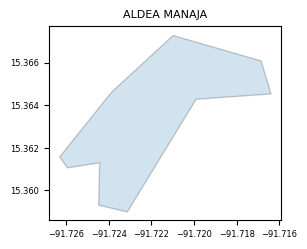

In [8]:
# Vizualizing the community in focus
fig, ax = plt.subplots(figsize=(3, 3))
cluster_polygons.plot(ax=ax, edgecolor='black', alpha=0.2)
ax.set_aspect('equal', 'box')
txt = ax.set_title('{}'.format(community), size=8)
ax.tick_params(axis='x', labelcolor='black', labelsize=6)
ax.tick_params(axis='y', labelcolor='black', labelsize=6)

### 3.2 Environmental characteristics: retrieving GHI and temperature

The Global Horizontal Irradiation (GHI) and temperature data can be retrieved from [renewables ninja](https://www.renewables.ninja). Before proceeding, please consult the [documentation](https://www.renewables.ninja/documentation) as creating a user account and password is necessary to generate a token for downloading specific data. You can do this by following the steps below:
1. Create a free account on the Renewables.ninja [website](https://www.renewables.ninja/register). Once registered, users gain the ability to download datasets and utilize the API for programmatic data retrieval.<br>
<br>
2. Log in. To access a personal API token, navigate to the profile by clicking on the symbol in the top right corner (usually a profile picture or icon) on [profile](https://www.renewables.ninja/profile).<br>
<br>
3. Within the profile settings, users can find their unique API token. This token should be copied and pasted between quotation marks (token = 'your_token_here') when using the API in the code.

In [9]:
longitude = cluster_polygons.geometry.centroid.x[0]    ## retrieved using the centroid of the polygon
latitude = cluster_polygons.geometry.centroid.y[0]     ## retrieved using the centroid of the polygon

In [10]:
token = 'YOUR_TOKEN'     ## To be retrieved through renewables ninja

**Execute the data acquisition function**

In [11]:
get_pv_data(latitude, longitude, token, pv_data_folder)

Data already in the PV folder


By executing the function a Comma-Separated Values (CSV) file named pv_data_lat_yyyy_long_xxxx.csv should have been downloaded. In case that there have been changes in the latitude, longitude coordinates, the name of the file (yyyy,xxxx) will be different. This file contains the following data:

+ time: Structured in hourly format.
+ ghi: Units are in watt-hours (Wh).
+ temperature: Units are in degrees Celsius (°C).

| time                     | ghi | temperature |
|--------------------------|-----|-------------|
| 2019-12-31 18:00:00-06:00| 0.0 | 23.407       |
| 2019-12-31 19:00:00-06:00| 0.0 | 22.95       |


Finally, the read_environmental_data function defines two variables to extract 8,760 values for GHI and temperature. The function is designed to output two NumPy arrays containing this data. 

**Important Note**: If better access to higher-quality environmental data is available, it should be formatted identically to the expected structure of hourly_ghi and hourly_temp..

In [12]:
hourly_ghi, hourly_temp = read_environmental_data(os.path.join(pv_data_folder, 'pv_data_lat_{}_long_{}.csv'.format(latitude, longitude)))

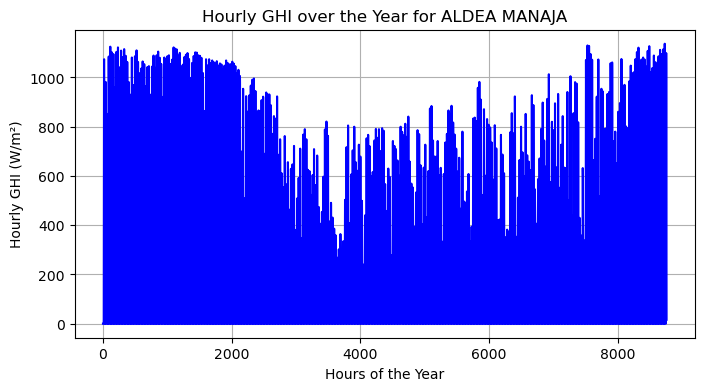

In [13]:
# Generate the array for hours of the year
hours_of_year = np.arange(8760)  # Array from 0 to 8759
# Create the plot
plt.figure(figsize=(8, 4))
plt.plot(hours_of_year, hourly_ghi, marker='', linestyle='-', color='b')
# Labeling the axes
plt.xlabel('Hours of the Year')
plt.ylabel('Hourly GHI (W/m²)')
# Adding a title
plt.title('Hourly GHI over the Year for {}'.format(community))
# Show grid
plt.grid(True)
# Display the plot
plt.show()

### 3.3 Building footprints

Building footprints provide information on the location of houses to be electrified, which is crucial for determining the size of the minigrid's distribution network. Here, we are using data from [Google-Microsoft Open Buildings by VIDA](https://beta.source.coop/vida/google-microsoft-open-buildings/). The data can be downloaded directly from the link under the Download section on the provided link. 

The downloaded file will be in .fgb format and is quite large (around 2.2 GB for Guatemala). To optimize local resources, it is a good practice to clip the data in QGIS before using it in a notebook. Sample buildings withing "Input_Data" for "Aldea Manaja" have already been extracted for this exercise.

In [14]:
households = gpd.read_file(r'Input_Data\{} blds.gpkg'.format(community))
households.head(3)

,boundary_id,bf_source,confidence,area_in_meters,geometry
0,41,google,0.8065,61.6836,"POLYGON ((-91.72510 15.36188, -91.72512 15.361..."
1,41,google,0.8895,116.7294,"POLYGON ((-91.72493 15.36203, -91.72497 15.362..."
2,41,google,0.7894,16.4130,"POLYGON ((-91.72497 15.36262, -91.72498 15.362..."


---------------------------------

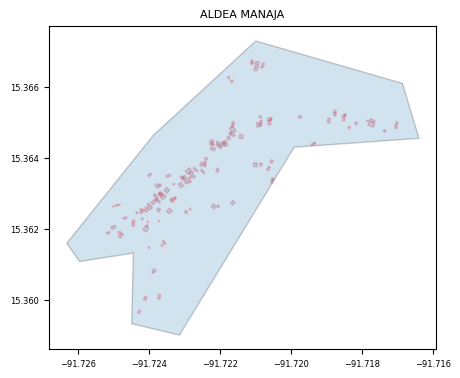

In [15]:
# Vizualizing structures within the community in focus
fig, ax = plt.subplots(figsize=(5, 5))
cluster_polygons.plot(ax=ax, edgecolor='black', alpha=0.2)
households.plot(ax=ax, edgecolor='red', alpha=0.2)
ax.set_aspect('equal', 'box')
txt = ax.set_title('{}'.format(community), size=8)
ax.tick_params(axis='x', labelcolor='black', labelsize=6)
ax.tick_params(axis='y', labelcolor='black', labelsize=6)

In [16]:
# Define bins and labels
bins = [0, 20, 50, 150, float('inf')]
labels = ['<20 m2', '20-50 m2', '50-150 m2', '>150 m2']

# Calculate the statistics without adding a new column
area_brackets = pd.cut(households['area_in_meters'], bins=bins, labels=labels, right=False)
bracket_stats = area_brackets.value_counts().sort_index()

# Add the total sum as value per column
for label in labels:
    cluster_polygons[label] = bracket_stats[label]


print ("Total structures:", households.shape[0])
print (bracket_stats)

Total structures: 125
area_in_meters
<20 m2       15
20-50 m2     36
50-150 m2    63
>150 m2      11
Name: count, dtype: int64


### 3.2 Demand

There are two primary methods for acquiring demand data:

**OPTION 1.** Rough assumption of type of customers (based on developers experience) + indicative load curves per type

**OPTION 2.** Site-Specific Data --> more detailed load profile per type of user (if available)

 ------------------------------

#### OPTION 1. Load profile estimation based on predefined archetypes

Under this approach, number of customers and demand load curves per type of customer are derived based on empirical data. You can find the sample load curves in [Input_data](./Input_data).

#### Rough prediction of customer per type (residential bundle A, bundle B, bundle C, SME or PUE)

In [17]:
reasonablecons = 1        ## Connectivity rate of structures - for now this value should not be changed 
smeshare = 0.08             ## Share of sme customers as % of total potential connections
bundleCshare = 0.08         ## Share of Residential Bundle C customers as % of total potential connections
bundleBshare = 0.36         ## Share of Residential Bundle B customers as % of total potential connections

cluster_polygons["Connections_All"] = np.ceil(cluster_polygons["<20 m2"] + 
                               cluster_polygons["20-50 m2"]+ 
                               cluster_polygons["50-150 m2"]+ 
                               cluster_polygons[">150 m2"]).astype(int)

cluster_polygons["Potential_Con"] = np.ceil(cluster_polygons["Connections_All"]*reasonablecons)

def assignPUoE(a, b, c, d, e):
    puoe = int(round(-2.913362564 + (-0.00415764*a) + (0.008440603*b) + (0.016433547*c) + (0.722331464*d) + (-0.040674586*e),0))
    if puoe <=0:
        return 0
    else:
        return puoe

cluster_polygons["PUoE"] = cluster_polygons.apply(lambda row: assignPUoE(row["<20 m2"],
                                             row["20-50 m2"],
                                             row["50-150 m2"],
                                             row[">150 m2"],
                                             0), axis=1)

cluster_polygons["SME"] = np.ceil((cluster_polygons["Potential_Con"] - cluster_polygons["PUoE"])*smeshare)
    
cluster_polygons["ResC"] = np.ceil((cluster_polygons["Potential_Con"] - cluster_polygons["PUoE"])*bundleCshare)
                     
cluster_polygons["ResB"] = np.ceil((cluster_polygons["Potential_Con"] - cluster_polygons["PUoE"])*bundleBshare)
                     
cluster_polygons["ResA"] = (cluster_polygons["Potential_Con"] - cluster_polygons["PUoE"] - cluster_polygons["SME"] - cluster_polygons["ResC"]- cluster_polygons["ResB"])

In [18]:
cluster_polygons

,id,COMUNIDAD,ÁREA,geometry,<20 m2,20-50 m2,50-150 m2,>150 m2,Connections_All,Potential_Con,PUoE,SME,ResC,ResB,ResA
0,None,ALDEA MANAJA,None,"MULTIPOLYGON (((-91.72597 15.36109, -91.72634 ...",15,36,63,11,125,125.0,6,10.0,10.0,43.0,56.0


In [19]:
#load_curve = calc_load_curve(tier_load, total_demand)
load_curve = calc_load_curve(cluster_polygons["ResA"][0],
                             cluster_polygons["ResB"][0],
                             cluster_polygons["ResC"][0],
                             cluster_polygons["SME"][0],
                             cluster_polygons["PUoE"][0])

----------------------------------

#### OPTION 2. Site-Specific Data (if available)

This approach requires that demand load curves adhere to a specific data structure to be compatible with the *load_curve* variable. This format requires 8760 hourly values representing hourly consumption in kW. 

In [20]:
# demand_csv = pd.read_csv('PATH_TO_CSV')
# load_curve = demand_csv['Demand_col']

------------------------------

Regardless of the approach used the *annual_demand* is a variable should be specified for the use to calculate LCOE..

In [21]:
annual_demand = sum(load_curve)

## 4. Technical and economic assumptions

### 4.1 Technical and economic assumptions for optimisation of the generation

The following technical and economic parameters are used for the optimization of generation in the microgrid. Please update these values based on the specific local context of analysis to ensure accurate results. Be mindful of units, as inconsistencies can lead to unexpected outcomes.

**General parameters**

In [22]:
start_year=2024
end_year=2049
discount_rate=0.08      ##The annual rate of return expected on an investment over the project's lifetime. This value is expressed as a percentage

**Diesel generator**

In [23]:
diesel_price=0.872     ## Diesel Price (USD/liter): The cost of diesel fuel used for generator operation
diesel_cost=350        ## Diesel Generator Cost (USD/kW): The initial capital cost of purchasing and installing a diesel generator, per kilowatt of rated power
diesel_om=0.1           ## Diesel Operational and mainenance Cost (USD/kW/year): The annual cost of operating and maintaining the diesel generator, share of CAPEX
diesel_life=10         ## Diesel Generator Lifetime (years): The expected number of years the diesel generator will be operational before requiring replacement
diesel_limit=0.5       ## Diesel Limit (0-1): This value sets the maximum allowable contribution of the diesel generator to the microgrid's annual electricity generation. It is expressed as a decimal between 0 and 1

**Batteries | Storage**

In [24]:
battery_cost=400           ## Battery Capital Cost (USD/kWh): The initial capital cost of purchasing and installing a battery storage system, per kilowatt-hour of storage capacity
full_life_cycles=2000      ## Battery Lifetime (cycles): The expected number of full charge/discharge cycles the battery can undergo before reaching its end of life
battery_inverter_cost=250  ## Battery Inverter Cost (USD/kW): The initial capital cost of purchasing and installing a battery inverter, per kilowatt of power
battery_inverter_life=20   ## Battery Inverter Lifetime (years): The expected number of years the battery inverter will be operational before requiring replacement
n_chg=0.90                 ## Battery Charging Efficiency (0-1): This parameter represents the efficiency of the battery charging process, accounting for energy losses during charging cycles. It is expressed as a decimal between 0 and 1
n_dis=0.9                  ## Battery Discharging Efficiency (0-1): This parameter represents the efficiency of the battery discharging process, accounting for energy losses during discharging cycles. It is expressed as a decimal between 0 and 1
dod_max=0.9                ## Dept-of-discharge (DOD) (0-1): DOD represents the percentage of a battery's total capacity that has been discharged in a single cycle, relative to its full charge capacity. It is expressed as a decimal between 0 and 1

**Solar panels  & Inverter**

In [25]:
pv_cost=1200          ## PV Panel Cost (USD/kWp): The initial capital cost of purchasing and installing photovoltaic (PV) panels, per watt-peak (Wp) of rated power output
pv_om=0.025           ## PV O&M Cost (USD/kWp/year): The annual cost of operating and maintaining the PV system, share of CAPEX. This includes costs for cleaning, monitoring, and minor repairs
pv_inverter=175       ## PV Inverter Cost (USD/kWp): The initial capital cost of purchasing and installing a solar inverter, per kilowatt-peak (Wp) of PV installed capacity. If this cost is already included in the PV Panel Cost, set this value to 0
charge_controller=0   ## Solar Charge Controller Cost (USD/kWp): The initial capital cost of purchasing and installing a solar charge controller, per kilowatt-peak (Wp) of PV panel capacity. If this cost is already included in the PV Panel Cost, set this value to 0
pv_life=25            ## PV System Lifetime (years): The expected number of years the PV system (panels and inverter) will be operational before requiring replacement
inv_eff=0.93          ## Inverter Efficiency (0-1): This parameter represents the efficiency of the inverter, which accounts for energy losses during conversion from DC to AC

**Minigrid parameter**

Loss of Power Supply Probability (LPSP): This parameter indicates the reliability of the microgrid in supplying electricity. A lower LPSP signifies a more reliable system with a lower chance of power outages.

In [26]:
lpsp_max=0.005

### 4.2 Technical and economic assumptions for optimisation of the generation

The sizing process generates two outputs related to the distribution grid: a GeoJSON file containing detailed information about the designed grid, disaggregated by the type of line (trunk, lateral, service drop), and a point layer file for poles that specifies their spatial locations. By incorporating capital costs (installation costs) and operational costs into the analysis, it's possible to estimate the Levelized Cost of Energy (LCOE) for the entire distribution network. To calculate the LCOE, you'll need the following variables:

Cost of distribution lines (USD/km), which refers to the capital cost associated with installing one kilometer of distribution lines within the community

In [27]:
cost_grid_km = 2000     ## LV line (0.2 – 0.4 kV) | Cost of low voltage distribution (approximation) -- overhead line, ABC type 100 mm2 Aluminium

Cost of Poles (USD/Pole): which refers to the capital cost associated with installing supporting poles for distribution

In [28]:
cost_pole = 150+26+72.2+34+60     ## pole + overhead accessories + lightning protection + labour cost --> per pole
pole_dist = 50                    ## meters

Service drop | Customer connection costs

In [29]:
con_cost = 173 # overhead access. | meter | ready board+rectifier

Operational & Maintenance costs (% initial investment): The annual cost of operating and maintaining the grid as percentage of initial investment

In [30]:
grid_om = 0.05

### 4.3 Labour and logistics costs

In [31]:
labour_cost =  100      ## Labour cost ~ 100 USD/kWp
trans_cost = 27         ## Transportation of material | 27 USD/connection

### 4.4 Selling general and administrative (SG&A) costs

In [32]:
sga_cost = 18          ## $/connection/year ($1.5/con/month) which adds to the operation and maintenance costs

In [33]:
total_cost_sga = sga_cost*len(households)

## 5. Optimization for Generation Sizing

The *optimizer_de* function finds the least-cost design for a microgrid system. It considers economic and techincal factors through user-provided data (look step No 4). First, it calculates total electricity demand and defines acceptable ranges for PV, battery, and diesel generator capacities. Then, it creates an objective function (opt_func) that calculates the Levelized Cost of Energy (LCOE) for a specific system configuration. This involves simulating electricity generation from PV, battery usage, and diesel reliance based on hourly data. Finally, it employs a Differential Evolution algorithm to search for the combination of PV, battery, and diesel capacities that minimizes the overall LCOE for the microgrid system. 

The function returns the optimal system configuration (PV, battery, and diesel capacities) that achieves the minimum LCOE for the microgrid system, as well as other variables that are of interest to analize: unmet demand, diesel generaton share, investment, fuel cost, Operational & Maintenance Cost, battery energy and battery life. 

In [34]:
additional_values_storage = []

def optimizer_de(diesel_price,
                 hourly_ghi,
                 hourly_temp,
                 load_curve,
                 diesel_cost,  # diesel generator capital cost, USD/kW rated power
                 discount_rate,
                 n_chg,  # charge efficiency of battery
                 n_dis,  # discharge efficiency of battery
                 battery_cost,  # battery capital cost, USD/kWh of storage capacity
                 pv_cost,  # PV panel capital cost, USD/kW peak power
                 charge_controller,  # PV charge controller cost, USD/kW peak power, set to 0 if already included in pv_cost
                 pv_inverter,  # PV inverter cost, USD/kW peak power, set to 0 if already included in pv_cost
                 pv_life,  # PV panel expected lifetime, years
                 diesel_life,  # diesel generator expected lifetime, years
                 pv_om,  # annual OM cost of PV panels
                 diesel_om,  # annual OM cost of diesel generator
                 battery_inverter_cost,
                 battery_inverter_life,
                 dod_max,  # maximum depth of discharge of battery
                 inv_eff,  # inverter_efficiency
                 lpsp_max,  # maximum loss of load allowed over the year, in share of kWh
                 diesel_limit,
                 full_life_cycles,
                 start_year,
                 end_year,
                 ):

    demand = load_curve.sum()

    # The following lines defines the solution space for the Particle Swarm Optimization (PSO) algorithm
    battery_bounds = [0, 5 * demand / 365]
    pv_bounds = [0, 5 * max(load_curve)]
    diesel_bounds = [0.5, max(load_curve)]
    
    min_bounds = np.array([pv_bounds[0], battery_bounds[0], diesel_bounds[0]])
    max_bounds = np.array([pv_bounds[1], battery_bounds[1], diesel_bounds[1]])
    bounds = Bounds(min_bounds, max_bounds)

    # Create a series of the hour numbers (0-24) for one year
    hour_numbers = np.empty(8760)
    for i in range(365):
        for j in range(24):
            hour_numbers[i * 24 + j] = j

    def opt_func(X):
        global additional_values_storage  # Use global variable to store additional values
        results = find_least_cost_option(X, hourly_temp, hourly_ghi, hour_numbers,
                                         load_curve, inv_eff, n_dis, n_chg, dod_max,
                                         diesel_price, end_year, start_year, pv_cost, charge_controller, pv_inverter, pv_om,
                                         diesel_cost, diesel_om, battery_inverter_life, battery_inverter_cost, diesel_life, pv_life,
                                         battery_cost, discount_rate, lpsp_max, diesel_limit, full_life_cycles)
        
        lcoe = results[0]
        additional_values_storage = results[1:]  # Capture additional values
                                       
        return lcoe

    minimizer_kwargs = {"method": "BFGS"}
    pv_init = sum(pv_bounds) / 2
    battery_init = sum(battery_bounds) / 2
    diesel_init = sum(diesel_bounds) / 2
    x0 = [pv_init, battery_init, diesel_init]
    
    result = differential_evolution(opt_func, bounds, popsize=15, init='latinhypercube')  # init='halton' on newer env

    best_solution = result.x
    lcoe = opt_func(best_solution)  # This call will also update additional_values_storage
    
    return {
        "best_solution": best_solution,
        "lcoe": lcoe,
        "additional_values": additional_values_storage
    }

The following line will execute the function optimizer_de and store the results in the variable ret. It finishes with a message on the expected LCOE and the install capacities for Solar Panels, Batteries and diesel.

In [35]:
ret = optimizer_de(diesel_price=diesel_price, 
                   hourly_ghi=hourly_ghi,
                   hourly_temp=hourly_temp,
                   load_curve=load_curve,
                   start_year=start_year,
                   end_year=end_year,
                   discount_rate=discount_rate,
                   diesel_cost=diesel_cost,  
                   battery_cost=battery_cost,  
                   full_life_cycles=full_life_cycles, 
                   battery_inverter_cost=battery_inverter_cost,  
                   pv_cost=pv_cost,  
                   pv_inverter=pv_inverter, 
                   charge_controller=charge_controller, 
                   diesel_limit=diesel_limit, 
                   lpsp_max=lpsp_max,
                   inv_eff=inv_eff,
                   n_chg=n_chg,
                   n_dis=n_dis,
                   dod_max=dod_max,
                   pv_om=pv_om,
                   diesel_om=diesel_om,
                   battery_inverter_life=battery_inverter_life,
                   pv_life=pv_life,
                   diesel_life=diesel_life)  

Examining some parameters within the ret variable provides insight into the optimization's progress.

In [36]:
print('Best LCOE: {} USD/kWh'.format(round(ret["lcoe"],3)))
print('Best PV capacity: {} kW'.format(round(ret["best_solution"][0],1)))
print('Best Battery capacity: {} kWh'.format(round(ret["best_solution"][1],1)))
print('Best Diesel capacity: {} kW'.format(round(ret["best_solution"][2],1)))

Best LCOE: 0.269 USD/kWh
Best PV capacity: 17.0 kW
Best Battery capacity: 68.4 kWh
Best Diesel capacity: 0.7 kW


In [37]:
total_cost_labour = round(ret["best_solution"][0],1) * labour_cost

## 6. Distribution Network Sizing

This section will define quantities for the distribution grid and poles in the minigrid. The required data includes the cluster of the minigrid and the geolocation of the households. The following code explanation will clarify how it can be adapted with own data. The first step involves exploring the data to identify relevant attributes. For instance, the "Polygones" file likely contains attributes that describe the polygon geometry of a cluster. We can start by examining the GeoPandas file to understand the available attributes and then retrieve the geometry information for the cluster.

In [38]:
cluster_polygons.head(2)

,id,COMUNIDAD,ÁREA,geometry,<20 m2,20-50 m2,50-150 m2,>150 m2,Connections_All,Potential_Con,PUoE,SME,ResC,ResB,ResA
0,None,ALDEA MANAJA,None,"MULTIPOLYGON (((-91.72597 15.36109, -91.72634 ...",15,36,63,11,125,125.0,6,10.0,10.0,43.0,56.0


The following steps involve using the "COMUNIDAD" column to identify the corresponding multipolygon shape from the "geometry" column. As mentioned earlier, the retrieved demand data pertains to a specific community within the administrative area of San Gaspar Ixchil. Therefore, the relevant geometry is the one associated with the community named "ALDEA MANAJA" within this area. It's important to note that all the spatial analysis discussed here was conducted  with QGIS.

### Setting up households layer

The households layer was previously uploaded as Polygon Layer. The following lines changed the geometry to point and defines a new layer *households_centroids* with the *target_crs* for Guatemala

In [39]:
households_centroids_crs = households.copy()
households_centroids_crs["geometry"] =  households['geometry'].centroid
households_centroids = households_centroids_crs.to_crs(target_crs)
households_centroids.head()

,boundary_id,bf_source,confidence,area_in_meters,geometry
0,41,google,0.8065,61.6836,POINT (636831.883 1698755.635)
1,41,google,0.8895,116.7294,POINT (636847.471 1698772.926)
2,41,google,0.7894,16.4130,POINT (636848.259 1698838.387)
3,41,google,0.7838,27.1953,POINT (636857.666 1698841.738)
4,41,google,0.7518,13.4064,POINT (636864.530 1698843.620)


In [40]:
# This will retrieve the polygon with the attribute 'COMUNIDAD' equal to the community name. This may need updating if working with another dataset
polygon_data = cluster_polygons.loc[cluster_polygons['COMUNIDAD'] == community]
polygon_data = polygon_data.to_crs(target_crs)
polygon = polygon_data.geometry.iloc[0]

#### Trunk Line Generation

This process outlines a method for generating a primary trunk line for settlements represented by polygon boundaries. 

1. **Boundary Points**: The user defines a spacing distance (default 50 meters) to create a set of evenly spaced points along the settlement polygon boundary.
2. **Voronoi Polygons**: These points are used to divide the settlement polygon into smaller regions called Voronoi polygons.
3. **Initial Trunk Line**: Edges of the Voronoi polygons are extracted, but any edge touching the settlement boundary is removed. This creates a preliminary version of the primary trunk line.
4. **Simplifying the Trunk Line**: Intersections where the trunk line branches off are identified. Only segments of the trunk line meeting these criteria are kept:
    * Located between two identified intersections.
    * Longer than a user-specified distance threshold.
5. **Splitting the Trunk Line**: The identified intersections are used to split the primary trunk line into separate segments. Any remaining long segments exceeding a user-defined distance threshold are also split.

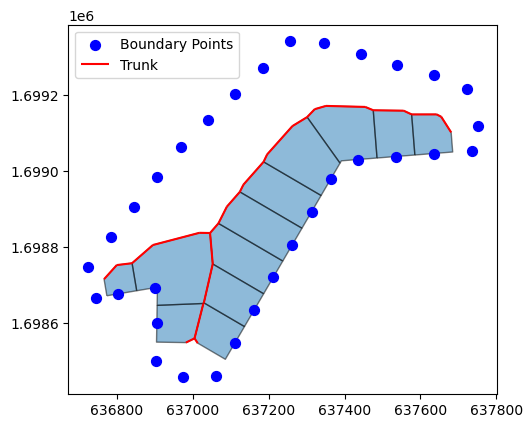

In [41]:
# Create trunk line(s)
trunk_lines = create_trunk_line(polygon, spacing=100, plot=True)

# Simplify the trunk line(s)
trunk_lines, intersects = simplify_trunk_lines(trunk_lines, length_removal=200, split_distance=750, plot=False)

trunk_lines_gdf = gpd.GeoDataFrame(geometry=trunk_lines)

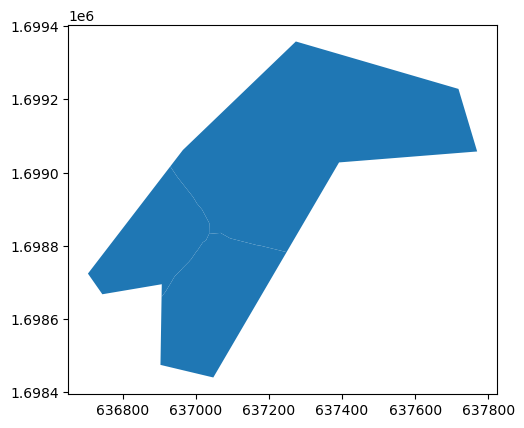

In [42]:
# Identify which part of the polygon belongs to which part of the trunk line(s)
voronois = voronoi_areas(trunk_lines_gdf, polygon, plot=True)

#### Pole locations

With the voronoi areas, now the focus is on identifying poles to where households will be connected. In each sub-area of the settlement polygon:
1. A mesh of evenly spaced points (default distance = 50 m) are created
2. Points are aligned to the x- and y-axis of the minimum bounding rectangle that can encapsulate the sub-area.
3. Any point that is close to the primary trunk line (default distance = 25 m) is excluded, as it is assumed that buildings within this distance would connect to a pole along the primary trunk line.
4. Buildings are assigned to the nearest of the candidate poles created in the previous step.
5. Finally, a Minimum Spanning Tree is created using NetworkX, to identify the secondary lines. The weights of the MST are assigned to favor in order:
    +  lines that are (near) orthogonal to the primary trunk
    + lines that are (near) parallel to the primary trunk 
    + diagonal lines 
    
The MST is run iteratively, testing the removal of poles to which no building was assigned until the shortest MST has been achieved (i.e. no more of the poles without households can be removed).

In [43]:
trunk_p = []
assigned_p = []
lv_l = []
service_l = []
mst_p = []
all_p = []
long_services = 0

multi_trunks = []
multi_trunks_len = []

multi_secondary = []
multi_secondary_len = []

multi_service = []
multi_service_len = []

multi_poles = []
multi_all_poles = []

# Iterate over each part of the trunk line 
for id in range(len(trunk_lines)):
    all_poles, trunk_poles, poles, angle_radians_w, angle_radians_l = create_candidate_poles_old(voronois[id], trunk_lines[id], pole_dist, buffer=25, plot=False)

    trunk_p += trunk_poles
    all_p += all_poles
        
    polygon_households = households_centroids.clip(voronois[id])

    # Ensure households are not MultiPoint
    polygon_households['geometry'] = polygon_households['geometry'].apply(convert_multipoint_to_point)

    assigned_poles, service_drops = assign_households(all_poles, polygon_households)

    assigned_p += all_poles
    service_l += service_drops

    for s in service_drops:
        if s.length > 70:
            long_services += 1

    weight = 0.5  # Weighting factor for the MST

    lv_lines, mst_poles = lv_lines_mst(all_poles, trunk_poles, assigned_poles, angle_radians_w, angle_radians_l, weight, plot=False)

    lv_l += lv_lines
    mst_p += mst_poles

### Results

Geometry results from the sizing model (distribution networ and poles) are appended into a list and then store in geopandas format.

Appending geometry results from previous sizing:

In [44]:
multi_all_poles.append(MultiPoint(all_p))

multi_trunks.append(MultiLineString(trunk_lines))
multi_trunks_len.append(MultiLineString(trunk_lines).length)

multi_secondary.append(MultiLineString(lv_l))
multi_secondary_len.append(MultiLineString(lv_l).length)

multi_service.append(MultiLineString(service_l))
multi_service_len.append(MultiLineString(service_l).length)

multi_poles.append(MultiPoint(mst_p))

Assigning appended geometry results to GeoPandas format:

In [45]:
trunks_gdf = gpd.GeoDataFrame()
trunks_gdf['Length'] = multi_trunks_len
trunks_gdf['Type'] = "Trunk Line"
trunks_gdf.geometry = multi_trunks
trunks_gdf.set_crs(target_crs, inplace=True)
trunks_gdf['Community'] = community

secondary_gdf = gpd.GeoDataFrame()
secondary_gdf['Length'] = multi_secondary_len
secondary_gdf['Type'] = "Secondary Line"
secondary_gdf.geometry = multi_secondary
secondary_gdf.set_crs(target_crs, inplace=True)
secondary_gdf['Community'] = community

service_gdf = gpd.GeoDataFrame()
service_gdf['Length'] = multi_service_len
service_gdf['Type'] = "Service Line"
service_gdf.geometry = multi_service
service_gdf.set_crs(target_crs, inplace=True)
service_gdf['Community'] = community

poles_gdf = gpd.GeoDataFrame()
poles_gdf.geometry = multi_poles
for i, multi_pole in enumerate(multi_poles):
    num_poles = len(multi_pole.geoms)
poles_gdf['No. Poles'] = num_poles
poles_gdf.set_crs(target_crs, inplace=True)
poles_gdf['Community'] = community
poles_gdf.to_crs(4326, inplace=True)

Finally, all the individual MultiLineString GeoDataGrames can be merged into a single GeoDataFrame for further analysis.

In [46]:
total_grid_gdf = gpd.GeoDataFrame(pd.concat([trunks_gdf, secondary_gdf, service_gdf], ignore_index=True))

The *total_grid_df* contains the three different kind of connection, and it is one of the main outputs of the OnSSET-MG tool.

### Cost of distribution

Earlier in the notebook *cost_grid_km* was defined. Now, the cost of the distribution grid can be estimated following the next equation:

In [47]:
cost_grid = cost_grid_km * (sum(trunks_gdf["Length"])/1000 + sum(secondary_gdf["Length"])/1000)
cost_service_drops = con_cost*(sum(service_gdf['Length'])/1000)

*Cost_pole* was also defined, and it can also be called in this part to estimate the total cost of installing all the poles.

In [48]:
total_cost_poles = cost_pole * sum(poles_gdf["No. Poles"])

With the two defined variables *cost_grid* and *total_cost_poles*, the total cost of the grid is as follows:

In [49]:
total_cost_grid = cost_grid + cost_service_drops + total_cost_poles

And Finally, the annual cost of Operationan & Maintenance are calculated based on a percentage of the total Capital Costs.

In [50]:
total_om_grid = grid_om * total_cost_grid

The function to define de LCOE for the distribution grid can be calculated from the set of functions available in the OnSSET-MG tool. Notices that within the function, the time life of the grid was set in 30 years.

In [51]:
lcoe_distribution = calculate_distribution_lcoe(end_year=end_year, 
                            start_year=start_year, 
                            annual_demand=annual_demand, 
                            distribution_cost=total_cost_grid, 
                            om_costs=total_om_grid, 
                            distribution_life=30, 
                            discount_rate=discount_rate)

In [52]:
project_life = end_year - start_year
total_sga = 0
for year in range(project_life):
    total_sga += total_cost_sga / ((1 + discount_rate) ** year)

Transportation costs are defined as follows:

In [53]:
transportation_costs = trans_cost*len(households)

## 7. Analysis

From the previous section there are several outputs of interest, but in this part the focus will be on the variable *ret* and the GeoPandas dataframes *total_grid_gdf* and *poles_gdf*. On this regard, a better presentation of the results could be as:

In [54]:
results = {
    "Name": ["PV Capacity [kWp]",
             "Battery capacity [kWh]", 
             "Diesel Capacity [kW]",
             "Annual diesel fuel usage [litre]",
              
             "Trunk Line [km]",
             "Laterals [km]",
             "Service lines [km]",
             "No Poles",         
             
             "CAPEX generation [USD]",
             "CAPEX Distribution [USD]",
             "Cost of Labour [USD]",
             "Cost of Transport [USD]",
             "Total CAPEX [USD]",
             
             "OPEX Generation [USD]",
             "OPEX Distribution [USD]",
             "OPEX SG&A [USD]",
             "Total OPEX [USD]",
             "Annual OPEX [USD]",
             "NPC [USD]",
             
             "lcoe [USD/kWh]",
       
            ],
    
    
    "Value": [round(ret["best_solution"][0],1), #PV_Capacity
              round(ret["best_solution"][1],1),  #Battery Capacity
              round(ret["best_solution"][2],1), #Diesel Capacity
              round(ret["additional_values"][10],2), #Diesel fuel usage
              
              round(sum(trunks_gdf["Length"])/1000,1), #kilometers_grid_main_line
              round(sum(secondary_gdf["Length"])/1000,1), #kilometers_grid_secondary_lines
              round(sum(service_gdf["Length"])/1000,1),#kilometers_services_drops
              sum(poles_gdf["No. Poles"]), #Number of poles
              
              round(ret["additional_values"][2],3), # CAPEX of generation - total_cost_labour - transportation_costs, #Cost of Assets
              round(total_cost_grid,0), # CAPEX of distribution
              total_cost_labour, #Cost of Labour
              transportation_costs, #Cost of transport
              round(total_cost_grid,0) + math.ceil(round(ret["additional_values"][2],3)) + total_cost_labour + transportation_costs, #Total_capex
              
              round(ret["additional_values"][4],0) + round(ret["additional_values"][3],0), #Total OPEX Generation
              round(lcoe_distribution[2],0), #Total OPEX Distribution
              round(total_sga, 0),
              round(ret["additional_values"][4] + ret["additional_values"][3] + lcoe_distribution[2] + total_sga, 0), #Total OPEX
              round(ret["additional_values"][-1] + lcoe_distribution[-1] + total_cost_sga, 0), #Annual OPEX
              round(ret["additional_values"][9] + lcoe_distribution[3] + total_sga + total_cost_labour + transportation_costs, 0), # Net Present Costs
              
              round(ret["lcoe"],3) + round(lcoe_distribution[0],3), #lcoe_generation + lcoe_distribution
             ]
}

results_pd = pd.DataFrame(results, columns=["Name", "Value"])

# Assign result columns to the original community aplha shape
for key, value in results_pd.set_index('Name')['Value'].to_dict().items():
    cluster_polygons[key] = value

results_pd

,Name,Value
0,PV Capacity [kWp],17.000
1,Battery capacity [kWh],68.400
2,Diesel Capacity [kW],0.700
3,Annual diesel fuel usage [litre],86.880
4,Trunk Line [km],1.400
5,Laterals [km],2.000
6,Service lines [km],2.800
7,No Poles,67.000
8,CAPEX generation [USD],87810.145
9,CAPEX Distribution [USD],30232.000


### 7. Results

The results can be exported. Specifically, CSV files will be generated from some of the dataframes, and the same process can be applied to the GeoDataFrames. Earlier in the notebook the *outpath* folder was defined to stored out results:

#### Exporting summary results as .CSV

In [55]:
name_file = community + "_Results"
results_pd.to_csv(os.path.join(outpath, name_file +".csv"))

#### Exporting simulated distribution lines into a .gpkg

In [56]:
name_gpd_file_d = os.path.join(outpath, "{} distribution_grid.gpkg".format(community))
name_gpd_file_c = os.path.join(outpath, "{} results.gpkg".format(community))

## Export trunk lines
trunks_gdf.to_crs(origin_crs, inplace=True)
trunks_gdf.to_file(name_gpd_file_d, layer='Trunk_line', driver='GPKG')

## Export laterals
secondary_gdf.to_crs(origin_crs, inplace=True)
secondary_gdf.to_file(name_gpd_file_d, layer='Laterals', driver='GPKG')

## Export service lines
service_gdf.to_crs(origin_crs, inplace=True)
service_gdf.to_file(name_gpd_file_d, layer='Service_lines', driver='GPKG')

## Export poles
#poles_gdf.to_crs(origin_crs, inplace=True)
poles_gdf.to_file(name_gpd_file_d, layer='Poles', driver='GPKG')

#### Exporting community with results into a .gpkg

In [57]:
cluster_polygons.to_file(name_gpd_file_c, layer=community, driver='GPKG')